# Project 3 #
#### Sashwath Sundher ####

Import libraries.

In [1]:
import numpy as np
import pandas as pd

Read dataframes.

In [2]:
data_units = pd.read_csv('data/BrandTotalUnits.csv', thousands=',')
data_sales = pd.read_csv('data/BrandTotalSales.csv', thousands=',')
data_arp = pd.read_csv('data/BrandAverageRetailPrice.csv', thousands=',')
data_details = pd.read_csv('data/BrandDetails.csv', thousands=',')

Convert Months into time series.

In [3]:
data_units['Months'] = pd.to_datetime(data_units['Months'])
data_sales['Months'] = pd.to_datetime(data_sales['Months'])
data_arp['Months'] = pd.to_datetime(data_arp['Months'])

Plot total monthly sales across all brands over time.

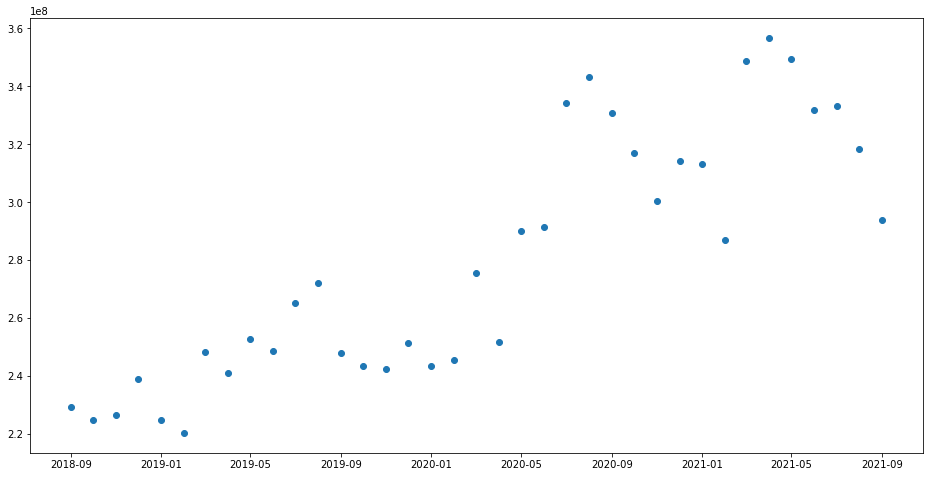

In [4]:
from matplotlib import pyplot, dates

months = data_sales['Months'].unique()
all_sales = []
for month in months:
    monthly_sales = sum(data_sales[data_sales.Months == month]['Total Sales ($)'])
    all_sales.append(monthly_sales)
months = dates.date2num(months)
pyplot.figure(figsize=(16,8))
pyplot.plot_date(months, all_sales)

Fill `top_increments` to calculate the feature cross 'Price Score'. `top_increments` stores the 4 best selling '$5 Price Increments' for each product type in 'Category L2'.

In [5]:
# Get the unique categories
categories = data_details['Category L2'].unique()
# Get the unique increments
increments = data_details['$5 Price Increment'].unique()
# Collect top_increments for each category
top_increments = {}
# Iterate through categories
for category in categories:
    # Separate data of current category
    category_data = data_details.loc[data_details['Category L2'] == category]
    # Collect total_sales in each price increment for current category
    total_sales = []
    for increment in increments:
        increment_data = category_data.loc[category_data['$5 Price Increment'] == increment]
        total_sales.append((increment, sum(increment_data['Total Sales ($)'])))
    # Sort the sales to get the top price increments
    total_sales.sort(key=lambda tup:tup[1])
    # Store top price increments for current category
    top_increments[category] = [tup[0] for tup in total_sales[-4:]]

Iterate through brands. Prepare the data for each brand. Combine the brands into a clean dataframe.

In [6]:
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Get the unique brands
brands = data_details['Brand'].unique()

# Initialize empty dataframe
data = pd.DataFrame()

# Iterate through brands
for brand in brands:
    
    # Prepare units dataframe
    units = data_units[data_units.Brands == brand]
    units.rename(columns={'vs. Prior Period' : 'Change in Units'}, inplace=True)

    # Add features based on time series
    units.insert(4, 'Previous Month Units', units.loc[:, 'Total Units'].shift(1))
    units.insert(5, 'Rolling Average Units', units.loc[:, 'Total Units'].shift(1) +
                                             units.loc[:, 'Total Units'].shift(2) +
                                             units.loc[:, 'Total Units'].shift(3))
    units.insert(6, 'Previous Change in Units', units.loc[:, 'Change in Units'].shift(1))

    # Prepare sales dataframe for merge
    sales = data_sales[data_sales.Brand == brand].copy()
    sales.drop('Brand', axis=1, inplace=True)
    
    # Add features based on time series
    sales.insert(2, 'Previous Month Sales', sales.loc[:, 'Total Sales ($)'].shift(1))
    sales.insert(3, 'Rolling Average Sales', sales.loc[:, 'Total Sales ($)'].shift(1) +
                                             sales.loc[:, 'Total Sales ($)'].shift(2) +
                                             sales.loc[:, 'Total Sales ($)'].shift(3))
    sales.insert(4, 'Change in Sales', sales.loc[:, 'Total Sales ($)'].shift(1) -
                                       sales.loc[:, 'Total Sales ($)'].shift(2))

    # Prepare arp dataframe for merge
    arp = data_arp[data_arp.Brands == brand].copy()
    arp.drop('Brands', axis=1, inplace=True)
    arp.rename(columns={'vs. Prior Period' : 'Change in ARP'}, inplace=True)

    # Merge units, sales, arp
    units = units.merge(sales, left_on='Months', right_on='Months')
    units = units.merge(arp, left_on='Months', right_on='Months')

    # Prepare the details dataframe for feature extraction
    details = data_details[data_details.Brand == brand]

    # Extract features from details

    # Find total number of well_priced products in this brand
    well_priced = 0
    # Iterate through categories
    for category in categories:
        # Separate data of current category
        category_data = details.loc[details['Category L2'] == category]
        # Find number of products in each increment
        increment_counts = category_data['$5 Price Increment'].value_counts()
        # Find number of products in well_priced increments
        for increment in top_increments[category]:
            if increment in increment_counts.index:
                well_priced += increment_counts[increment]
    # Calculate price_score as percentage of well_priced products out of all products
    price_score = well_priced / (details.Brand == brand).count()
    # Store the price score
    units['Price Score'] = price_score
    
    # Find the product type this brand stocks most
    flagship_type = details['Category L2'].value_counts().index[0]
    # Store the flagship type
    units['Flagship Type'] = flagship_type
    
    # Separate products of flagship type
    flagship_products = details.loc[details['Category L2'] == flagship_type]
    # Store the total sales across all flagship products
    units['Flagship Sales'] = sum(flagship_products['Total Sales ($)'])

    # Store the number of different product types this brand sells
    units['Type Count'] = len(details['Category L2'].unique())

    # Store the number of different products this brand sells
    units['Product Count'] = (details.Brand == brand).count()
    
    # Append brand data to all data
    data = data.append(units)

Drop features that we do not want to train with.

In [7]:
data.drop('Total Units', axis=1, inplace=True)
data.drop('Change in Units', axis=1, inplace=True)
data.drop('Total Sales ($)', axis=1, inplace=True)

Make 'Months' the index of the dataframe.

In [8]:
data.set_index('Months', inplace=True)

Plot correlations between features.

<AxesSubplot:>

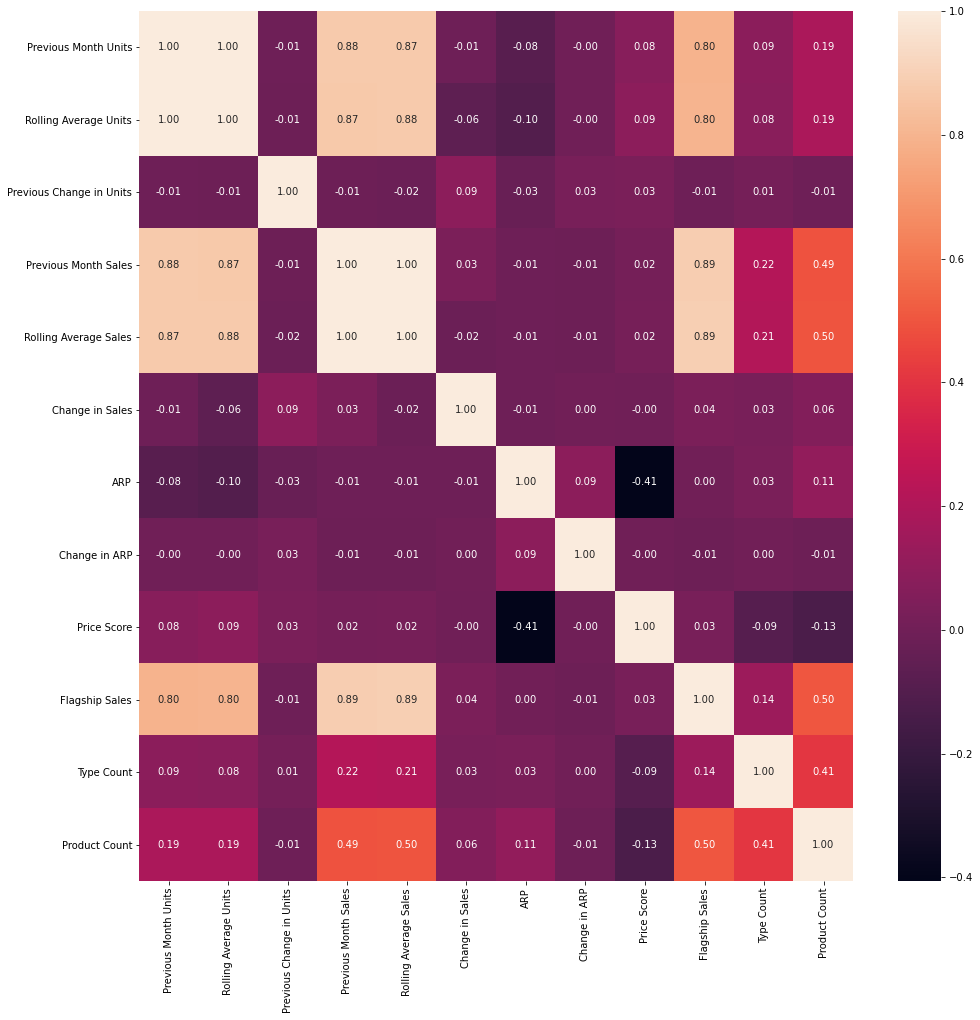

In [9]:
import seaborn

pyplot.figure(figsize=(16, 16))
seaborn.heatmap(data.corr(), annot=True, fmt='.2f')

Drop rows with null labels.

In [10]:
data.dropna(subset=['Change in Sales'], inplace=True)

Separate the label.

In [11]:
delta_sales = data.pop('Change in Sales')

Impute null values with forward fill.

In [12]:
data.groupby('Brands').fillna(method='ffill', inplace=True)

""


Drop any remaining rows with null values.

In [13]:
not_null = data.notna().all(axis=1)
data = data[not_null]
delta_sales = delta_sales[not_null]

Define scaling and encoding pipeline to preprocess data.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['Brands', 'Flagship Type']
numerical_features = list(data.drop(columns=categorical_features))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])

Split train and test data.

In [15]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_sales, test_sales = train_test_split(data, delta_sales, test_size=0.2)

Define helper function for model evaluation.

In [16]:
from sklearn import metrics

def show_regression_results(y_true, y_pred):
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('Explained Variance: ', round(explained_variance, 4))    
    print('MAE: ', round(mean_absolute_error, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))
    #print('MSLE: ', round(mean_squared_log_error, 4))
    print('R2: ', round(r2, 4))

Train and test with Linear Regression model.

In [17]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

pipeline.fit(train_data, train_sales)

show_regression_results(test_sales, pipeline.predict(test_data))

Explained Variance:  0.749
MAE:  40726.7757
RMSE:  104992.6182
R2:  0.749


Train and test with Random Forest Regressor model.

In [18]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)

pipeline.fit(train_data, train_sales)

show_regression_results(test_sales, pipeline.predict(test_data))

Explained Variance:  0.8303
MAE:  26481.7318
RMSE:  86330.402
R2:  0.8303


Train and test with Support Vector Regressor model.

In [19]:
from sklearn.svm import SVR

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", SVR())]
)

pipeline.fit(train_data, train_sales)

show_regression_results(test_sales, pipeline.predict(test_data))

Explained Variance:  0.0001
MAE:  81870.781
RMSE:  209547.5437
R2:  0.0


Introduce Truncated SVD into pipeline to reduce dimensionality.

In [31]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=6)

Train and test with Linear Regression model.

In [32]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("tsvd", tsvd), ("regressor", LinearRegression())]
)

pipeline.fit(train_data, train_sales)

show_regression_results(test_sales, pipeline.predict(test_data))

Explained Variance:  0.0129
MAE:  80924.7819
RMSE:  208214.4033
R2:  0.0127


Train and test with Random Forest Regressor model.

In [33]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("tsvd", tsvd), ("regressor", RandomForestRegressor())]
)

pipeline.fit(train_data, train_sales)

show_regression_results(test_sales, pipeline.predict(test_data))

Explained Variance:  0.31
MAE:  54125.9101
RMSE:  174067.1109
R2:  0.31


Train and test with SVR model.

In [34]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("tsvd", tsvd), ("regressor", SVR())]
)

pipeline.fit(train_data, train_sales)

show_regression_results(test_sales, pipeline.predict(test_data))

Explained Variance:  0.0001
MAE:  81865.7469
RMSE:  209545.3483
R2:  0.0


Use K-fold Cross Validation and Grid Search to optimize the models.

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=10, random_state=1, shuffle=True)

Define helper function for Grid Search evaluation.

In [36]:
def show_gridsearch_results(results):
    print(f'Best Neg MAE Score: {results.best_score_}')
    print(f'Best Hyperparameters: {results.best_params_}')

Process data for GridSearch.

In [50]:
data_copy = data.copy()
data_copy.drop('Brands', axis=1, inplace=True)
data_copy.drop('Flagship Type', axis=1, inplace=True)
scaler = StandardScaler()
processed = scaler.fit_transform(data_copy)

Optimize Linear Regression model.

In [46]:
param_grid = {
    'fit_intercept' : ['True', 'False'],
    'positive' : ['True', 'False']
}

model = LinearRegression()
lin_reg_cv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv)
results = lin_reg_cv.fit(processed, delta_sales)

show_gridsearch_results(results)

Best Neg MAE Score: -81522.30128720791
Best Hyperparameters: {'fit_intercept': 'True', 'positive': 'True'}


Optimize Random Forest Regressor model.

In [47]:
param_grid = {
    'n_estimators': [50, 100, 200, 250],
    'max_depth': [10, 15, 20]
}

rf_reg = RandomForestRegressor()
rf_reg_cv = GridSearchCV(estimator=rf_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv)
result = rf_reg_cv.fit(processed, delta_sales)

show_gridsearch_results(result)

Best Neg MAE Score: -25839.237422196133
Best Hyperparameters: {'max_depth': 15, 'n_estimators': 250, 'n_jobs': -1}


Optimize SVR model.

In [54]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    'max_iter': [100]
    
}

svr = SVR()
svr_cv = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
result = svr_cv.fit(processed, delta_sales)

show_gridsearch_results(result)

Best Neg MAE Score: -156449.40762880206
Best Hyperparameters: {'C': 1000, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 100}


C:\Users\sns7a\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [57]:
import statsmodels.api as sm

avo_stats = sm.OLS(delta_sales, processed)
results_stats = avo_stats.fit()

print(results_stats.summary())

                                 OLS Regression Results                                
Dep. Variable:        Change in Sales   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              5276.
Date:                Sun, 05 Dec 2021   Prob (F-statistic):                        0.00
Time:                        10:55:19   Log-Likelihood:                     -2.1643e+05
No. Observations:               16696   AIC:                                  4.329e+05
Df Residuals:                   16685   BIC:                                  4.330e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [60]:
data_copy.head()

,Previous Month Units,Rolling Average Units,Previous Change in Units,Previous Month Sales,Rolling Average Sales,ARP,Change in ARP,Price Score,Flagship Sales,Type Count,Product Count
Months,,,,,,,,,,,
2020-04-01,943.393328,1985.465207,0.354169,30465.470533,62522.895107,32.934344,0.019844,0.467532,115292.416742,2,77
2020-05-01,712.498102,2352.549861,-0.244750,23465.657692,74197.889232,34.441725,0.045769,0.467532,115292.416742,2,77
2020-06-01,619.841032,2275.732462,-0.130045,21348.394472,75279.522697,33.114497,-0.038535,0.467532,115292.416742,2,77
2020-07-01,426.150450,1758.489584,-0.312484,14111.757773,58925.809937,32.131407,-0.029688,0.467532,115292.416742,2,77
2020-08-01,589.719394,1635.710876,0.383829,18948.514108,54408.666353,32.146382,0.000466,0.467532,115292.416742,2,77
